In [98]:
%matplotlib inline

In [82]:
import os
from dotenv import load_dotenv
import weaviate
import weaviate.classes as wvc
import numpy as np

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = weaviate.connect_to_local(
            headers={
                "X-OpenAI-Api-Key": api_key
            }
        )

In [83]:
client.collections.delete("trendingSchema")
client.collections.delete("latestSchema")

trendingSchema = client.collections.create(
            name = "trendingSchema",
            description = "A class to store information regarding meme coins.",
            properties = [
                wvc.config.Property(
                    name="description",
                    data_type=wvc.config.DataType.TEXT,
                    description="This stores the description of the coin",
                ), 
            ],
        )
latestSchema = client.collections.create(
            name = "latestSchema",
            description = "A class to store information regarding meme coins.",
            properties = [
                wvc.config.Property(
                    name="description",
                    data_type=wvc.config.DataType.TEXT,
                    description="This stores the description of the coin",
                ), 
            ],
        )

In [ ]:
import requests
import json

# Api endpoint for trending tokens
url = "https://api.dexscreener.com/token-boosts/top/v1"

# Make the API request
response = requests.get(url)

# Collection to store trending data
collection = client.collections.get("trendingSchema")

# Check if the request was successful
if response.status_code == 200:
    data = response.json()  # Convert response to Python dictionary
    for item in data:
        uuid = collection.data.insert({
            "properties": {
                "description": item.get('description', 'No description'),
            }
        })
        print(f"{uuid}\n")

    
    

In [ ]:
# Api endpoint for latest tokens
url = "https://api.dexscreener.com/token-profiles/latest/v1"

# Make the API request
response = requests.get(url)

# Collection to store trending data
collection = client.collections.get("latestSchema")

# Check if the request was successful
if response.status_code == 200:
    data = response.json()  # Convert response to Python dictionary
    for item in data:
        uuid = collection.data.insert({
            "properties": {
                "description": item.get('description', 'No description'),
            }
        })
        print(f"{uuid}\n")

In [ ]:
# Fetch Vectors
trendingDataDesc = []
trendingDataVect = []
trendingData = client.collections.get("trendingSchema")
for item in trendingData.iterator(
    include_vector=True  # If using named vectors, you can specify ones to include e.g. ['title', 'body'], or True to include all 
):
    print(item.properties["properties"]["description"][0:9])
    trendingDataDesc.append(item.properties["properties"]["description"][0:8])
    trendingDataVect.append(item.vector["default"])

In [87]:
# Fetch Vectors
latestDataDesc = []
latestDataVect = []
latestData = client.collections.get("latestSchema")
for item in latestData.iterator(
    include_vector=True  # If using named vectors, you can specify ones to include e.g. ['title', 'body'], or True to include all
):
    latestDataDesc.append(item.properties["properties"]["description"][0:8])
    latestDataVect.append(item.vector["default"])

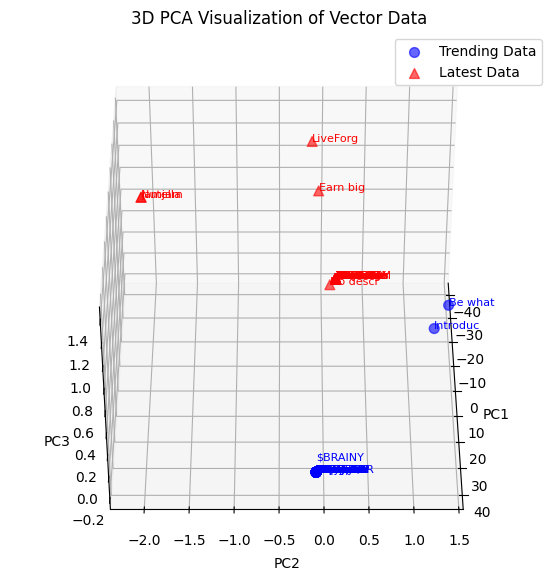

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


# Combine datasets for consistent PCA transformation
combined_data = np.vstack((trendingDataVect, latestDataVect))

# Handle NaN values by replacing them with column means
col_means = np.nanmean(combined_data, axis=0)
indices = np.where(np.isnan(combined_data))
combined_data[indices] = np.take(col_means, indices[1])

# Normalize the data for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Apply PCA to reduce to 3D
pca = PCA(n_components=3)
transformed_data = pca.fit_transform(scaled_data)

# Split transformed data back into respective datasets
trendingData3D = transformed_data[:len(trendingDataVect)]
latestData3D = transformed_data[len(trendingDataVect):]

# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.mouse_init()  # Enable interactive rotation

# Scatter plot with different colors
ax.scatter(trendingData3D[:, 0], trendingData3D[:, 1], trendingData3D[:, 2],
           c='blue', marker='o', label='Trending Data', alpha=0.6, s=50)
ax.scatter(latestData3D[:, 0], latestData3D[:, 1], latestData3D[:, 2],
           c='red', marker='^', label='Latest Data', alpha=0.6, s=50)

# Label each point
for i, txt in enumerate(trendingDataDesc):
    ax.text(trendingData3D[i, 0], trendingData3D[i, 1], trendingData3D[i, 2], txt, size=8, color='blue')
for i, txt in enumerate(latestDataDesc):
    ax.text(latestData3D[i, 0], latestData3D[i, 1], latestData3D[i, 2], txt, size=8, color='red')

# Set axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization of Vector Data')

# Add legend
ax.legend()

# Optimize viewing angle
ax.view_init(elev=40, azim=0)

# Show plot
plt.show()
